In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件。"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩。'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件。"""
    for name in DATA_HUB:
        download(name)

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [7]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [8]:
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
# 首列为id，与房价无关，因此进行剔除
# 对训练集与测试集的数据合并起来处理
new_data = pd.concat((train_data.iloc[:, 1:], test_data.iloc[:, 1:]))
new_data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [10]:
# 这部分对数值型的特征进行处理（归一化）
numeric_features = new_data.dtypes[new_data.dtypes != 'object'].index
new_data[numeric_features] = new_data[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有数据均值均变为0，因此我们可以将缺失值设置为0
new_data[numeric_features] = new_data[numeric_features].fillna(0)

In [11]:
#这部分对离散形式的非数值型特征进行处理,转变为one-hot向量的编码形式
# `Dummy_na=True` 将“na”（缺失值）视为有效的特征值，并为其创建指示符特征。
new_data = pd.get_dummies(new_data, dummy_na=True)
new_data.shape

(2919, 332)

In [24]:
# 将处理好的特征转换为tensor，便于pytorch的训练
n_train = train_data.shape[0]  # 训练数据的数量
train_features = torch.tensor(new_data[:n_train].values, dtype=d2l.float32)
test_features = torch.tensor(new_data[n_train:].values, dtype=d2l.float32)
train_labels = torch.tensor(new_data[:n_train].SalePrice.values.reshape(-1, 1), dtype=d2l.float32)
test_labels = torch.tensor(new_data[n_train:].values, dtype = d2l.float32)
print(train_features.shape)
print("-------------------------------------------")
print(train_labels.shape)

torch.Size([1460, 332])
-------------------------------------------
torch.Size([1460, 1])


In [18]:
# 先用一个简单版本线型模型进行训练
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

# 由于更关心误差相对于原价的比例，而非绝对的数值差异，因此转成log再做差(logx-logy = log(x/y))
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1,torch.clamp即将预测结果限制在1~inf之间
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

In [27]:
import torch.utils.data as data
def load_array(data_arrays, batch_size, shuffle = True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size= batch_size, shuffle=shuffle )

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = load_array((train_features, train_labels), batch_size=batch_size)
    optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X,y in train_iter:
#             print(X.shape)
#             print(y.shape)
#             print("----------------------------------------------------")
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features,train_labels))
        if test_labels != None:
            test_ls.append(log_rmse(net, test_features,test_labels))
    return train_ls, test_ls

In [15]:
# 进行K折交叉验证，以便于超参数的优化调整
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse nan, valid log rmse nan
fold 2, train log rmse nan, valid log rmse nan
fold 3, train log rmse nan, valid log rmse nan
fold 4, train log rmse nan, valid log rmse nan
fold 5, train log rmse nan, valid log rmse nan
5-折验证: 平均训练log rmse: nan, 平均验证log rmse: nan


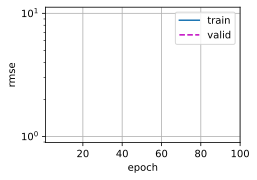

In [16]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [28]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train(get_net(), train_features, train_labels, test_features, test_labels,num_epochs, lr, weight_decay, batch_size)

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

D:\Coding\IDE\Anaconda3\envs\d2l-Pytorch-version\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1459, 332])) that is different to the input size (torch.Size([1459, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([52, 332])
torch.Size([52, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([52, 332])
torch.Size([52, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([52, 332])
torch.Size([52, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([52, 332])
torch.Size([52, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([52, 332])
torch.Size([52, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
----------------------------------------------------
torch.Size([64, 332])
torch.Size([64, 1])
--------

([nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan

In [31]:
net = get_net()
print(net(train_features))

tensor([[-0.3923],
        [-0.4130],
        [-0.4554],
        ...,
        [-0.2251],
        [-0.2374],
        [-0.2434]], grad_fn=<AddmmBackward0>)
